# Example use of the Julia module Sonic.Linckii

Note that the module depends on another module ```LinckiiSecrets``` for authentication, which is not part of the Git repository, and has to be added by hand.

In [1]:
import JuliaDB, Plots, Random, Unitful

┌ Info: Recompiling stale cache file /Users/jens/.julia/compiled/v1.2/JuliaDB/4FA8g.ji for JuliaDB [a93385a2-3734-596a-9a66-3cfbb77141e6]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jens/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


In [2]:
import Sonic

┌ Info: Recompiling stale cache file /Users/jens/.julia/compiled/v1.2/Sonic/R3ynV.ji for Sonic [40c42df8-6f87-4e82-b148-77c95cb09b7a]
└ @ Base loading.jl:1240


In [3]:
site_name = "keab"

"keab"

GET "https://canary.noda.se/$site_name/api/v1/node"

In [4]:
@time nodes = Sonic.Linckii.get_nodes(site_name)

  8.940177 seconds (15.68 M allocations: 822.614 MiB, 5.54% gc time)


Table with 279 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String

In [5]:
JuliaDB.pkeynames(nodes)

(:node_id,)

Flatten ```nodes```, i.e.,
```
flat_nodes = JuliaDB.rename(
    JuliaDB.flatten(nodes, :sensor_ids),
    :sensor_ids => :sensor_id,
)
```

In [6]:
flat_nodes = Sonic.Linckii.flatten_nodes(nodes)

Table with 4721 rows, 8 columns:
Columns:
#  colname           type
───────────────────────────
1  node_id           Int64
2  sensor_id         Int64
3  node_public       Bool
4  node_name         String
5  device_id         Int64
6  node_owner        Bool
7  node_enabled      Bool
8  node_description  String

In [7]:
JuliaDB.pkeynames(flat_nodes)

(:node_id, :sensor_id)

GET "https://canary.noda.se/$site_name/api/v1/device"

In [8]:
@time devices = Sonic.Linckii.get_devices(site_name)

  1.784677 seconds (2.09 M allocations: 108.322 MiB, 2.32% gc time)


Table with 11 rows, 3 columns:
protocol_id  device_name             device_id
──────────────────────────────────────────────
1            "Kelp-IQHeat"           1
2            "Scout"                 2
1            "Kelp-Basic"            4
5            "Weather-Forecast"      6
6            "Grid-Basic"            7
6            "Grid-Controller"       8
7            "Heat-Load-Forecast"    9
2            "CMa1Xw"                10
2            "EcoGuard Sensor"       11
2            "WEPTech"               12
8            "Flexibility-Forecast"  13

In [9]:
JuliaDB.pkeynames(devices)

(:device_id,)

GET "https://canary.noda.se/$site_name/api/v1/sensor"

In [10]:
@time sensors = Sonic.Linckii.get_sensors(site_name)

  3.406988 seconds (5.11 M allocations: 288.107 MiB, 3.27% gc time)


Table with 175 rows, 5 columns:
Columns:
#  colname             type
────────────────────────────────
1  sensor_unit         FreeUnits
2  sensor_name         Symbol
3  protocol_id         Int64
4  sensor_id           Int64
5  sensor_description  String

In [11]:
JuliaDB.pkeynames(sensors)

(:sensor_id,)

Get device sensors,

In [12]:
device_sensors = JuliaDB.reindex(
    JuliaDB.join(
        devices,
        sensors;
        lkey = :protocol_id,
        rkey = :protocol_id,
    ),
    (:device_id, :sensor_id),
)

Table with 341 rows, 7 columns:
Columns:
#  colname             type
─────────────────────────────
1  device_id           Int64
2  sensor_id           Int64
3  protocol_id         Int64
4  device_name         String
5  sensor_unit         Any
6  sensor_name         Symbol
7  sensor_description  String

In [13]:
JuliaDB.pkeynames(device_sensors)

(:device_id, :sensor_id)

Get node device sensors,

In [14]:
node_device_sensors = JuliaDB.reindex(
    JuliaDB.join(
        flat_nodes,
        device_sensors;
        lkey = (:device_id, :sensor_id),
        rkey = (:device_id, :sensor_id),
    ),
    (:node_id, :sensor_id),
)

Table with 4478 rows, 13 columns:
Columns:
#   colname             type
──────────────────────────────
1   node_id             Int64
2   sensor_id           Int64
3   device_id           Int64
4   node_public         Bool
5   node_name           String
6   node_owner          Bool
7   node_enabled        Bool
8   node_description    String
9   protocol_id         Int64
10  device_name         String
11  sensor_unit         Any
12  sensor_name         Symbol
13  sensor_description  String

In [15]:
JuliaDB.pkeynames(node_device_sensors)

(:node_id, :sensor_id)

Get side 1 substation data for 2019-09-01/2019-10-01 and 2019-10-01/2019-11-01,

In [16]:
pkeys = JuliaDB.select(
    JuliaDB.join(
        Sonic.Linckii.flatten_nodes(
            JuliaDB.filter(
                r -> r.node_id <= 20 && r.device_id == 4, # "r.node_id <= 20 && " is just there to speed up the testing
                nodes,
            ),
        ),
        JuliaDB.filter(
            r -> r.sensor_name in [
                :meter_effect,
                :meter_primreturntemp,
                :meter_primsupplytemp,
                :meter_volumeflow,
            ],
            device_sensors,
        );
        lkey = (:device_id, :sensor_id),
        rkey = (:device_id, :sensor_id),
    ),
    (:node_id, :sensor_name),
)

Table with 24 rows, 2 columns:
node_id  sensor_name
──────────────────────────────
1        :meter_effect
16       :meter_effect
17       :meter_effect
18       :meter_effect
19       :meter_effect
20       :meter_effect
1        :meter_primreturntemp
16       :meter_primreturntemp
17       :meter_primreturntemp
18       :meter_primreturntemp
19       :meter_primreturntemp
20       :meter_primreturntemp
1        :meter_primsupplytemp
16       :meter_primsupplytemp
17       :meter_primsupplytemp
18       :meter_primsupplytemp
19       :meter_primsupplytemp
20       :meter_primsupplytemp
1        :meter_volumeflow
16       :meter_volumeflow
17       :meter_volumeflow
18       :meter_volumeflow
19       :meter_volumeflow
20       :meter_volumeflow

In [17]:
dates = ["2019-09-01", "2019-10-01", "2019-11-01"]

3-element Array{String,1}:
 "2019-09-01"
 "2019-10-01"
 "2019-11-01"

Save data,

In [18]:
@time JuliaDB.save(Sonic.Linckii.get_data(site_name, pkeys, dates...), "Example Sonic.Linckii.db")

 75.327894 seconds (22.74 M allocations: 1020.028 MiB, 1.70% gc time)


Table with 140344 rows, 5 columns:
node_id  sensor_name        datetime             timezone  value
────────────────────────────────────────────────────────────────
1        :meter_effect      2019-09-01T00:06:02  2 hours   13
1        :meter_effect      2019-09-01T00:16:02  2 hours   13
1        :meter_effect      2019-09-01T00:26:02  2 hours   13
1        :meter_effect      2019-09-01T00:36:03  2 hours   13
1        :meter_effect      2019-09-01T00:46:03  2 hours   13
1        :meter_effect      2019-09-01T00:56:02  2 hours   13
1        :meter_effect      2019-09-01T01:06:02  2 hours   13
1        :meter_effect      2019-09-01T01:16:02  2 hours   14
1        :meter_effect      2019-09-01T01:26:03  2 hours   14
1        :meter_effect      2019-09-01T01:46:02  2 hours   13
1        :meter_effect      2019-09-01T01:56:02  2 hours   13
1        :meter_effect      2019-09-01T02:06:03  2 hours   13
⋮
20       :meter_volumeflow  2019-10-31T22:20:03  1 hour    972
20       :meter_volumeflow

Load data,

In [19]:
@time data = JuliaDB.load("Example Sonic.Linckii.db")

  0.520313 seconds (1.77 M allocations: 45.936 MiB, 9.86% gc time)


Table with 140344 rows, 5 columns:
node_id  sensor_name        datetime             timezone  value
────────────────────────────────────────────────────────────────
1        :meter_effect      2019-09-01T00:06:02  2 hours   13
1        :meter_effect      2019-09-01T00:16:02  2 hours   13
1        :meter_effect      2019-09-01T00:26:02  2 hours   13
1        :meter_effect      2019-09-01T00:36:03  2 hours   13
1        :meter_effect      2019-09-01T00:46:03  2 hours   13
1        :meter_effect      2019-09-01T00:56:02  2 hours   13
1        :meter_effect      2019-09-01T01:06:02  2 hours   13
1        :meter_effect      2019-09-01T01:16:02  2 hours   14
1        :meter_effect      2019-09-01T01:26:03  2 hours   14
1        :meter_effect      2019-09-01T01:46:02  2 hours   13
1        :meter_effect      2019-09-01T01:56:02  2 hours   13
1        :meter_effect      2019-09-01T02:06:03  2 hours   13
⋮
20       :meter_volumeflow  2019-10-31T22:20:03  1 hour    972
20       :meter_volumeflow

Simple plot,

In [26]:
node_id = JuliaDB.select(data, :node_id)[Random.rand(1 : end)]

20

In [27]:
sensor_name = JuliaDB.select(data, :sensor_name)[Random.rand(1 : end)]

:meter_primsupplytemp

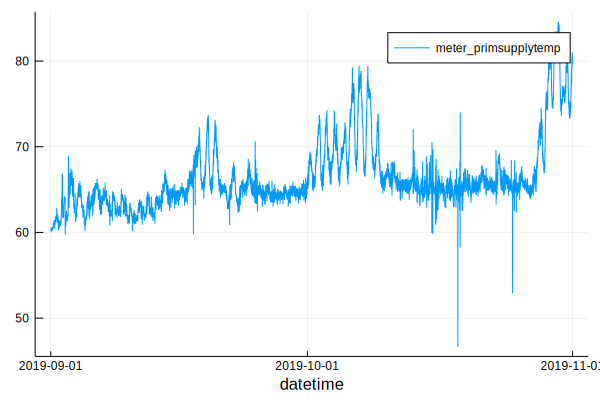

In [28]:
t = Sonic.Linckii.filter(r -> r.node_id == node_id && r.sensor_name == sensor_name, data)
x = JuliaDB.select(t, :datetime)
y = JuliaDB.select(t, :value)
Plots.plot(x, y, xlabel = :datetime, label = sensor_name)